# Deep Learning in Human Language Technologies 2020
# Text classification project

#### Group 2: Hanna Kitti, Dang Trinh Ha, Timo Jokela

Contributions:

xxxx

## Preparations

### Imports

In [1]:
import io
import numpy as np
import pandas as pd
import pprint
import pickle
import seaborn as sns
import torch
import transformers

from functools import partial
from matplotlib import pyplot as plt
from pathlib import Path
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm, trange

pp = pprint.PrettyPrinter(indent=4)

### Dataset

Data split

- Training set: used for training the models
- Validation (or model assessment) set: when comparing
different models trained on training set, select one with lowest
error on validation set
- Test set: test the final hypothesis on test set to get unbiased
error estimate for it

After error estimation the final model is often trained on
combined training, validation and test set, using best
hyperparameters found during model selection
- Complication: randomized optimization approaches where
different runs with same hyperparameters can lead to very
different quality solutions (e.g. neural network)

In [2]:
orig_columns = ['reg', 'text']

# load the data
df_train = pd.read_csv('fincore-train.tsv', sep='\t', names=orig_columns)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

df_dev_full = pd.read_csv('fincore-dev.tsv', sep='\t', names=orig_columns)
df_dev_full = (df_dev_full.sample(frac=1, random_state=42)
                          .reset_index(drop=True))

df_test_full = pd.read_csv('fincore-test.tsv', sep='\t', names=orig_columns)
df_test_full = (df_test_full.sample(frac=1, random_state=42)
                            .reset_index(drop=True))

The following classes of the test and development sets are not in the training set:

In [3]:
print("Dev/test classes not in the training set:\n")
print(df_test_full[~df_test_full.reg.isin(df_train.reg.unique())].reg.unique())
print(df_dev_full[~df_dev_full.reg.isin(df_train.reg.unique())].reg.unique())

Dev/test classes not in the training set:

['FC NA DP IN ' 'FC NA DT IN ' 'SL LY ' 'HI  IP IG ' 'IB IN IN  '
 'RE HI PB NA ' 'IT SP DT IN ' 'RV OP PB NA ' 'IP IG NE NA '
 'NE NA DT IN ' 'CB NA EB IG ' 'OA NA FC NA ' 'DS IG AV OP ']
['ID  PB NA ' 'DS IG MT OS ' 'DF ID NE NA ' 'OP  DP IN ' 'DF ID PB NA '
 'TB NA CB NA ']


Since we can not train the model to predict labels it has not seen during training phase, we will keep only rows in dev and test data which have the labels that appear also in training data:

In [4]:
df_test = df_test_full[
    df_test_full.reg.isin(df_train.reg.unique())].reset_index(drop=True)
df_dev = df_dev_full[
    df_dev_full.reg.isin(df_train.reg.unique())].reset_index(drop=True)

Texts for all the datasets:

In [5]:
txt_train = [x for x in df_train.text]
txt_dev = [x for x in df_dev.text]
txt_test = [x for x in df_test.text]

Encoded labels (registers):

In [6]:
# labels as numbers
label_encoder = LabelEncoder()
train_classes = label_encoder.fit_transform(df_train.reg)
dev_classes = label_encoder.transform(df_dev.reg)
test_classes = label_encoder.transform(df_test.reg)
num_classes = len(label_encoder.classes_)

## Milestone 1

For the first two models we construct vocabularies of alternative sizes:

In [7]:
print("Generating vocabularies...")
max_features_options = [1000, 10000, 20000, 30000, 40000, 50000]
ms1_vocabs = {}
for mf in max_features_options:
    # a vectorizer and the feature matrices for this particular max_features
    # NOTE: outside of this notebook other params were tested; see baseline
    vectorizer = CountVectorizer(max_features=mf,
                                 binary=False,
                                 ngram_range=(1, 1))
    ms1_vocabs[mf] = {
        'vectorizer': vectorizer,
        'train_fm': vectorizer.fit_transform(txt_train),
        'dev_fm': vectorizer.transform(txt_dev),
        'test_fm':  vectorizer.transform(txt_test)
    }
print("Done.")

Generating vocabularies...
Done.


### 1.0: Baseline (Naive Bayes)

Naive Bayes classifier to be used as a baseline. It is trained on the training data for each separate dataset (different _max_features_ params for the CountVectorizer). Additionally accuracy on the permutated test sets are computed for the purpose of ensuring that performance with actual data differs from performance with junk data.

In [8]:
def mnb_compute(X, y, mnb):
    predictions = mnb.predict(X)
    return (np.sum(predictions == y) / len(y), predictions)

bayes_results = {}
print("Computing stats for the MNB models...")
for max_feats, vocab in ms1_vocabs.items():
    # train using the training set
    mnb = MultinomialNB()
    mnb.fit(vocab['train_fm'], df_train.reg)

    # the accuracy of the trained model on all the sets
    train_accuracy, _ = mnb_compute(vocab['train_fm'], df_train.reg, mnb)
    dev_accuracy, _ = mnb_compute(vocab['dev_fm'], df_dev.reg, mnb)
    test_accuracy, test_preds = mnb_compute(vocab['test_fm'], df_test.reg, mnb)
    
    # accuracy on permutated test set
    permutated = np.random.permutation(df_test.reg)
    perm_accuracy, _ = mnb_compute(vocab['test_fm'], permutated, mnb)
    
    bayes_results[max_feats] = {
        'model': mnb,
        'train_accuracy': train_accuracy,
        'dev_accuracy': dev_accuracy,
        'test_accuracy': test_accuracy,
        'test_predictions': test_preds,
        'perm_accuracy': perm_accuracy,
    }
print("Done.")

Computing stats for the MNB models...
Done.


In [9]:
for mf, stats in bayes_results.items():
    print(f"\nMax features: {mf}\nACCURACY: "
          f"Train {stats['train_accuracy']:.2f}  "
          f"Dev {stats['dev_accuracy']:.2f}  "
          f"Test {stats['test_accuracy']:.2f}  "
          f"Permutated {stats['perm_accuracy']:.2f}  ")



Max features: 1000
ACCURACY: Train 0.60  Dev 0.47  Test 0.47  Permutated 0.07  

Max features: 10000
ACCURACY: Train 0.77  Dev 0.56  Test 0.53  Permutated 0.08  

Max features: 20000
ACCURACY: Train 0.79  Dev 0.56  Test 0.54  Permutated 0.09  

Max features: 30000
ACCURACY: Train 0.80  Dev 0.56  Test 0.54  Permutated 0.08  

Max features: 40000
ACCURACY: Train 0.80  Dev 0.55  Test 0.54  Permutated 0.07  

Max features: 50000
ACCURACY: Train 0.79  Dev 0.54  Test 0.53  Permutated 0.07  


**NOTE**: Outside of this notebook other params (*binary, ngram*) for the CountVectorizer were also tested. Neither here nor with the BOW model had they any practical effect whatsoever. Also, the value of the *max_features* parameter seems to be the most effective approximately in the range of 20 - 40 k, after which the accuracy begins to slowly degrade (possibly due to more features contributing only noise). 

**Having several different models for different parameter sets proved to be very demanding RAM-wise (particularly for BOW)**, and therefore, to keep the hardware requirements in check, we reduced the number of different *max_feature*s values to three:

In [10]:
%%capture
# limit the number of different max_features params
max_features_options = [1000, 10000, 30000]
ms1_vocabs.pop(20000)
ms1_vocabs.pop(50000)

### 1.1: BOW

We tried several optimizers, of which SGD and Adam seemed to be the most effective. Therefore we decided to cover only them in this notebook:

In [11]:
keras_optimizers = {
    'SGD': optimizers.SGD,
    'Adam': optimizers.Adam,
}

Next we define the function responsible for building the bow model.


**NOTE**: Outside of this notebook several alternative model constructions were tested. These included other forms of regularization (e.g. dropout), different setups for hidden layer(s) and using pre-computed weights due to the data being imbalanced. None of these had any practical effect.

In [12]:
def build_bow_model(
        feature_matrix, activation=None, optimizer=None, learning_rate=None
    ):
    """ Builds the BOW model according to the parameters """
    doc_count, feature_count = feature_matrix.shape
    inp = Input(shape=(feature_count,))
    hidden = Dense(250, activation=activation)(inp)
    output = Dense(num_classes, activation="softmax")(hidden)
    model = Model(inputs=[inp], outputs=[output])
    optimizer = optimizer(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

We also performed GridSearchCV for the following parameter combinations:
- max_features: 1000, 10000, 30000
- optimizers: SGD, Adam
- activation: tanh, ReLU
- learning rate:  0.00098, 0.00310, 0.00984, 0.03125, 0.09921, 0.31498, 1.0


**NOTE**: This is an extremely taxing process both time- and resource-wise (allocating in total 20 GB of RAM + some swap on the side). Therefore we do not repeat the full computation here, but only list some of the best results, with which we will proceed. Change *DO_BOW_GSCV* to **True** to run the full operation.

Given the availability of sufficient resources, it would also be an option to optimize several other factors (not necessarily using GridSearchCV if not applicable but by other means) such as hidden layer composition or dropout rate (if used). However, due to limited time and hardware we have to settle for the options mentioned above.

In [13]:
# set to True to perform GridSearchCV again
DO_BOW_GSCV = False

In [14]:
if DO_BOW_GSCV:
    mc = ModelCheckpoint(filepath='/tmp/bow_model.h5',
                         monitor='accuracy',
                         verbose=0,
                         save_best_only=True,
                         mode='auto')

    es = EarlyStopping(monitor='accuracy',
                       patience=20,
                       verbose=0,
                       restore_best_weights=True)

    bow_grid_params = {
        'activation': ['tanh', 'relu'],
        'optimizer': list(keras_optimizers.values()), 
        'learning_rate': np.logspace(-10, 0, num = 7, base = 2).tolist()
    }
    grid_results = {}
    for mf in max_features_options:
        print(f"GridSearchCV for param max_features={mf}")
        feature_matrix = ms1_vocabs[mf]['train_fm']

        def f(activation=None, optimizer=None, learning_rate=None):
            return build_bow_model(
                feature_matrix,
                activation=activation, 
                optimizer=optimizer,
                learning_rate=learning_rate
            )

        grid = GridSearchCV(
            estimator=KerasClassifier(
                build_fn=f, epochs=40, batch_size=32, verbose=0),
            param_grid=bow_grid_params,
            n_jobs=1,
            cv=3,
            verbose=0,
        )
        grid_results[mf] = grid.fit(
            feature_matrix.toarray(), train_classes, callbacks=[es, mc])
    print("Done.")

    bow_grid_results = {}
    for mf in max_features_options:
        res = grid_results[mf]
        bow_grid_results[mf] = {
            'params': res.cv_results_['params'],
            'rank_test_score': res.cv_results_['rank_test_score'],
            'mean_test_score': res.cv_results_['mean_test_score']
        }
    pickle.dump(bow_grid_results, open('bow_grid_results.p', 'wb'))
else:
    bow_grid_results = pickle.load(open('bow_grid_results.p', 'rb'))
    print("Loaded GridSearchCV results from a file.")

Loaded GridSearchCV results from a file.


The following parameter sets ranked the best:

In [15]:
bow_params = {}  # For storing the best models for final comparison
for mf in max_features_options:
    print(f"\n{'--' * 10}\nBest for max_features={mf}:")
    res = bow_grid_results[mf]
    rank = list(res['rank_test_score'])
    idx_best = [rank.index(x) for x in range(1, 4)]
    best = [res['params'][x] for x in idx_best]
    bow_params[mf] = best
    scores = [res['mean_test_score'][x] for x in idx_best]
    for i, r in enumerate(best):
        print(f"\n{['First:', 'Second:', 'Third:'][i]} (score {scores[i]:.3f})\n")
        pp.pprint(r)


--------------------
Best for max_features=1000:

First: (score 0.484)

{   'activation': 'tanh',
    'learning_rate': 0.0098431332023037,
    'optimizer': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>}

Second: (score 0.471)

{   'activation': 'relu',
    'learning_rate': 0.0098431332023037,
    'optimizer': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>}

Third: (score 0.465)

{   'activation': 'tanh',
    'learning_rate': 0.03125,
    'optimizer': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>}

--------------------
Best for max_features=10000:

First: (score 0.538)

{   'activation': 'tanh',
    'learning_rate': 0.0009765625,
    'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}

Second: (score 0.537)

{   'activation': 'tanh',
    'learning_rate': 0.0031003926796253885,
    'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}

Third: (score 0.528)

{   'activation': 'tanh',
    

As can be seen, *tanh* does consistently better than *ReLU*, at least in the context of GridSearchCV. As for the other params, the results are more varied, even though the scores between the parameter sets do not vary considerably. In any case, a line has to be drawn somewhere, and therefore we will perform the full training cycle only with the param sets defined above.

In addition, for regularization purposes, early stopping will be utilized.

In [16]:
# Early Stopping settings
mc = ModelCheckpoint(filepath='/tmp/bow_model.h5',
                     monitor='val_accuracy',
                     verbose=0,
                     save_best_only=True,
                     mode='auto')

es = EarlyStopping(monitor='val_accuracy',
                   patience=20,
                   verbose=0,
                   restore_best_weights=True)

# The parameters that are used in the training process
fit_params = {
    'batch_size': 32,
    'verbose': 0,
    'epochs': 100,
    'callbacks': [mc, es],
}

def train_bow_model(max_features, params, train_classes=train_classes):
    """ Returns a trained BOW model and results for the given parameters """
    
    # Get the correct vocabulary and define the validation set
    vocab = ms1_vocabs[max_features]
    fit_params['validation_data'] = (vocab['dev_fm'], dev_classes)
    
    # Build and train the model
    model = build_bow_model(vocab['train_fm'], **params)
    hist = model.fit(vocab['train_fm'].toarray(), train_classes, **fit_params)

    # compute predictions for all the sets
    train_preds = np.argmax(model.predict(vocab['train_fm'].toarray()), axis=1)
    train_acc = np.sum(np.equal(train_classes, train_preds)) / len(train_classes)
    
    dev_preds = np.argmax(model.predict(vocab['dev_fm'].toarray()), axis=1)
    dev_acc = np.sum(np.equal(dev_classes, dev_preds)) / len(dev_classes)
    
    test_preds = np.argmax(model.predict(vocab['test_fm'].toarray()), axis=1)
    test_acc = np.sum(np.equal(test_classes, test_preds)) / len(test_classes)
    
    return {
        'model': model,
        'hist': hist,
        'optimizer': params['optimizer'].__name__,
        'learning_rate': params['learning_rate'],
        'train_accuracy': train_acc,
        'validation_accuracy': dev_acc,
        'test_accuracy': test_acc,
        'test_predictions': test_preds
    }
    
bow_results = {}
for mf in max_features_options:
    bow_results[mf] = []
    print(f"\nTraining BOW for max_features={mf}")
    for i, param_set in enumerate(bow_params[mf]):
        print(f"Param set {i + 1}.", end=" ")
        bow_results[mf].append(train_bow_model(mf, param_set))
print("\nDone.")


Training BOW for max_features=1000
Param set 1. Param set 2. Param set 3. 
Training BOW for max_features=10000
Param set 1. Param set 2. Param set 3. 
Training BOW for max_features=30000
Param set 1. Param set 2. Param set 3. 
Done.


Then it's time for some results:

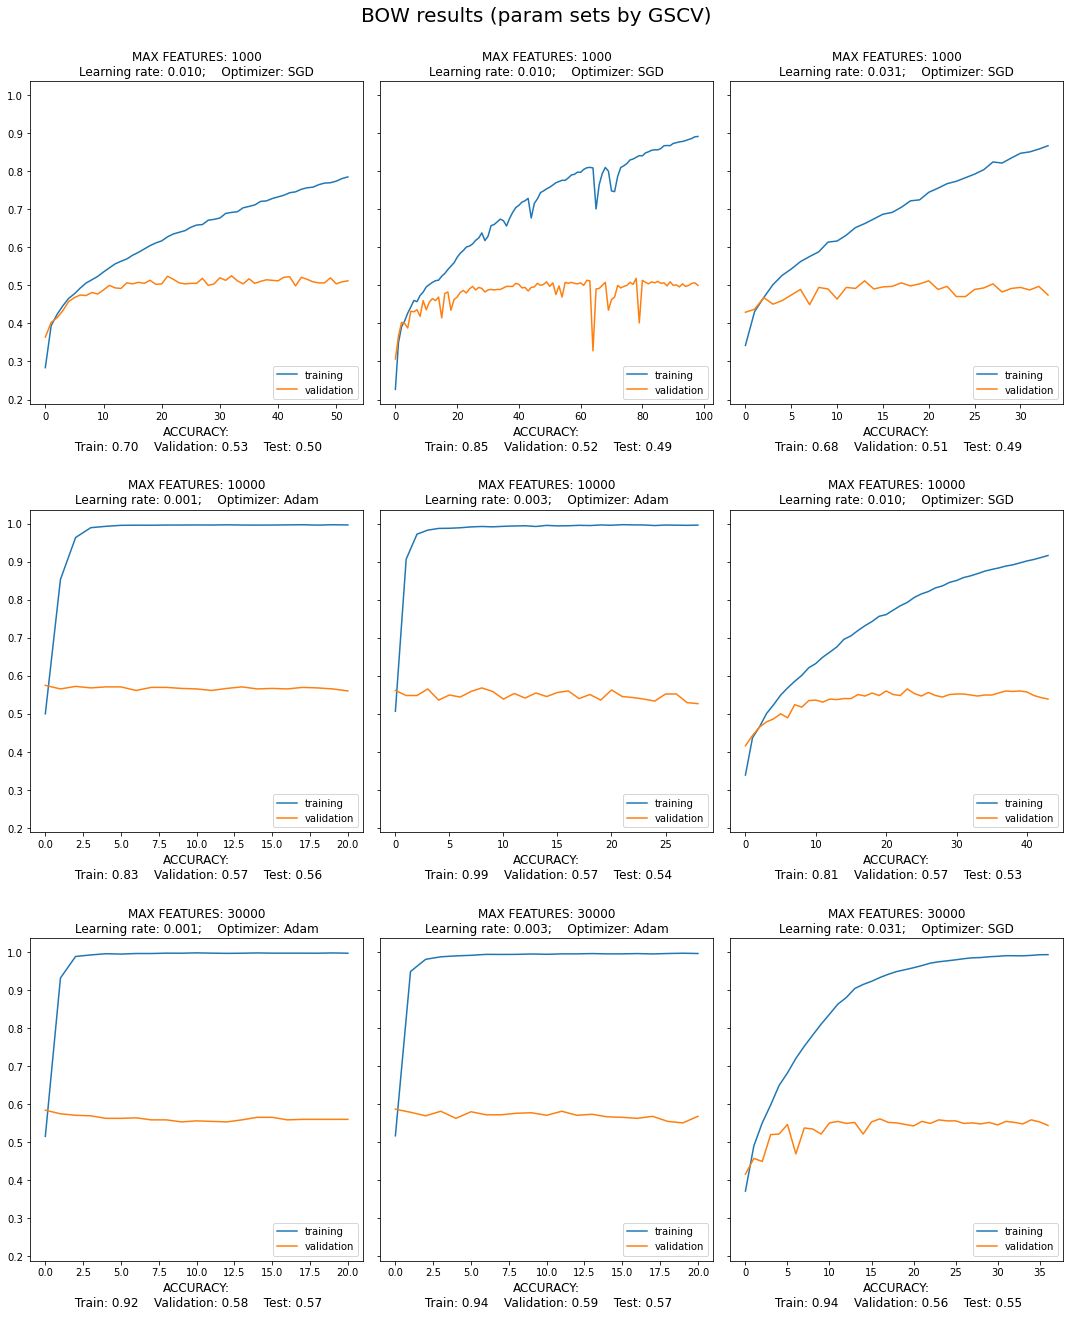

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(15, 18), sharey=True, tight_layout=True)
plt.suptitle("BOW results (param sets by GSCV)\n\n", va='baseline', fontsize=20)
for i, (mf, res_mf) in enumerate(bow_results.items()):
    for j, res in enumerate(res_mf):
        hist = res['hist'].history
        ax[i][j].set_title(f"MAX FEATURES: {mf}\n"
                        f"Learning rate: {res['learning_rate']:.3f};    "
                        f"Optimizer: {res['optimizer']}",
                        fontsize=12)
        ax[i][j].plot(hist['accuracy'], label='training')
        ax[i][j].plot(hist['val_accuracy'], label='validation')
        ax[i][j].set_xlabel(
            f"ACCURACY:\n Train: {res['train_accuracy']:.2f}    "
            f"Validation: {res['validation_accuracy']:.2f}    "
            f"Test: {res['test_accuracy']:.2f}\n",
            fontsize=12
        )
        ax[i][j].legend(loc='lower right')
plt.show()

As can be seen the results are downright lackluster. Optimizer-wise models with *Adam* do not seem to learn anything at all (or they learn everything they can during the first epoch). The exact value of *max_features* also seems to be somewhat irrelevant as long as it is within reasonable limits.

It should also be noted that the results displayed are clearly above results obtained from non-signal data. That is, if we permutate the training labels (effectively training with junk data) we obtain the following results:

In [18]:
permutated_bow = train_bow_model(
    10000,
    bow_params[10000][0],
    train_classes=np.random.permutation(train_classes))
print("Accuracies for a model trained with permutated data "
      "(best param set for max_features = 10000):\n"
      f"Train: {permutated_bow['train_accuracy']:.3f}\t"
      f"Dev: {permutated_bow['validation_accuracy']:.3f}\t"
      f"Test: {permutated_bow['test_accuracy']:.3f}")

Accuracies for a model trained with permutated data (best param set for max_features = 10000):
Train: 0.987	Dev: 0.099	Test: 0.101


**We will inspect the predictions more closely in Milestone 2.2.**

### 1.2: RNN

For RNN-calssifier we use Tokenizer which turns tokens, in our case the words of training data to integers.

In [ ]:
tokenizer = Tokenizer(num_words=100000, lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(txt_train)
train_seq = tokenizer.texts_to_sequences(txt_train)
dev_seq = tokenizer.texts_to_sequences(txt_dev)
test_seq = tokenizer.texts_to_sequences(txt_test)

In [ ]:
SEQ_LEN = 250
train_seq = pad_sequences(
    train_seq, maxlen=SEQ_LEN, padding='post',  truncating='post', value=0
)

dev_seq = pad_sequences(
    dev_seq, maxlen=SEQ_LEN, padding='pre',  truncating='pre', value=0
)

test_seq = pad_sequences(
    test_seq, maxlen=SEQ_LEN, padding='pre',  truncating='pre', value=0
)

In [ ]:
def build_rnn_model(
        RNN_class,
        sequence_length, 
        vocab_size,
        num_classes,
        embedding_dim=250,
        rnn_units=50, 
        drop=0.2, 
        rdrop=0.2
    ):
    input_ = Input(shape=(sequence_length,))
    embedding = Embedding(vocab_size, embedding_dim)(input_)
    # return_sequences=False is the default
    rnn = RNN_class(rnn_units, return_sequences=False)(embedding)
    #rnn = RNN_class(rnn_units, dropout=drop, recurrent_dropout=rdrop, return_sequences=False)(embedding)
    output = Dense(num_classes, activation='softmax')(rnn)
    return Model(inputs=[input_], outputs=[output])